# Supervised problem: experiments with optimization

I will build a small supervised problem to experiment with optimizers using Feed Forward Neural Networks

In [124]:
## routine needed to run the notebook on Google Colab
try:
    import google.colab

    IN_COLAB = True
except:
    IN_COLAB = False
if IN_COLAB:
    !pip install "pina-mathlab[tutorial]"

import warnings
import torch
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

from pina import Trainer
from pina import Condition, LabelTensor

from pina.domain import CartesianDomain
from pina.model import FeedForward
from pina.solver import SupervisedSolver

## Problem Building

I will build the same problem of the tutorial20 [Supervised Learning Tutorial](https://mathlab.github.io/PINA/tutorial20/tutorial.html)


In [125]:
def generate_sdf_data(num_points=1000000, radius=0.7, cube_bound=1.5):
    # Create the 3D cube
    domain = CartesianDomain(
        {
            "x": [-cube_bound, cube_bound],
            "y": [-cube_bound, cube_bound],
            "z": [-cube_bound, cube_bound],
        }
    )
    # Sample 3D points in cube
    coords = domain.sample(num_points, mode="random").tensor
    # Compute signed distance to the sphere
    sdf = coords.norm(dim=-1, keepdim=True) - radius  # ||x|| - r

    return coords, sdf

Here I wrap my data in a [LabelTensor](https://mathlab.github.io/PINA/_rst/label_tensor.html) since I initialize the problem myself

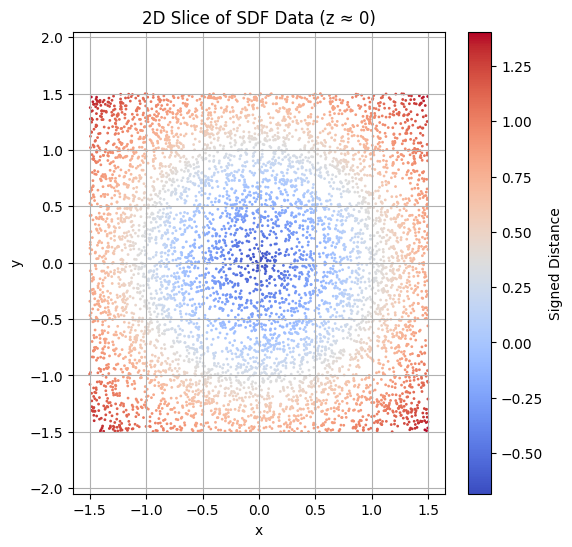

In [126]:
# --- Generate Data ---
coords, sdf = generate_sdf_data()

# Wrap data in LabelTensors
coords_l = LabelTensor(
    coords,
    ["x", "y", "z"]
)
sdf_l = LabelTensor(
    sdf,
    ["sdf"]
)

# --- 2D Slice at z ≈ 0 ---
z_slice_thresh = 0.01  # How close to z=0
mask_2d = coords_l[:, 2].abs() < z_slice_thresh
mask_2d = mask_2d.reshape(-1)  # Ensure mask is 1D
coords_2d = coords_l[mask_2d]
sdf_2d = sdf_l[mask_2d]

plt.figure(figsize=(6, 6))
plt.scatter(
    coords_2d[:, 0], coords_2d[:, 1], c=sdf_2d.squeeze(), cmap="coolwarm", s=1
)
plt.colorbar(label="Signed Distance")
plt.title("2D Slice of SDF Data (z ≈ 0)")
plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal")
plt.grid(True)
plt.show()

### Initializing the problem

The [tutorial](https://mathlab.github.io/PINA/tutorial20/tutorial.html) uses SupervisedProblem from pina.problem.zoo. Here I build the problem myself to get used to the interface 

In [127]:
from pina.problem import AbstractProblem

class mySupervisedProblem(AbstractProblem):
    input_variables = ["x", "y", "z"]
    output_variables = ["sdf"]
    conditions = {"data": Condition(input = coords_l, target = sdf_l)}

mysp = mySupervisedProblem()

Exploring the problem to understand how it works

In [128]:
mysp.are_all_domains_discretised

True

## Model building
Using the FeedForward class that PINA provides for now, then I will build one myself

In [129]:
model = FeedForward(
    func=torch.nn.Tanh,
    layers=[128] * 2,
    output_dimensions=len(mysp.output_variables),
    input_dimensions=len(mysp.input_variables),
)

## Solver
Things get interesting now. Experimenting with the built in optimizers, then I will build one myself

In [130]:
solver = SupervisedSolver(problem=mysp, model=model)

## Execute the solve

In [131]:
trainer = Trainer(solver=solver,
                  max_epochs=5,
                  accelerator="cuda",
                  train_size= 0.8,
                  test_size=0.2,
                  batch_size=1024,)
trainer.train()
_ = trainer.test()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type       | Params | Mode  | FLOPs
------------------------------------------------------------
0 | _pina_models | ModuleList | 17.2 K | train | 0    
1 | _loss_fn     | MSELoss    | 0      | train | 0    
------------------------------------------------------------
17.2 K    Trainable params
0         Non-trainable params
17.2 K    Total params
0.069     Total estimated model params size (MB)
9         Modules in trai

Epoch 4: 100%|██████████| 782/782 [00:02<00:00, 358.26it/s, v_num=25, data_loss_step=0.00028, train_loss_step=0.00028, data_loss_epoch=0.000229, train_loss_epoch=0.000229]  

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 782/782 [00:02<00:00, 357.73it/s, v_num=25, data_loss_step=0.00028, train_loss_step=0.00028, data_loss_epoch=0.000229, train_loss_epoch=0.000229]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 196/196 [00:00<00:00, 656.41it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch       0.0004812752886209637
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Epoch 21:  27%|██▋       | 21/79 [52:23<2:24:41,  0.01it/s, v_num=15, data_loss_step=0.000361, train_loss_step=0.000361, data_loss_epoch=0.000357, train_loss_epoch=0.000357]


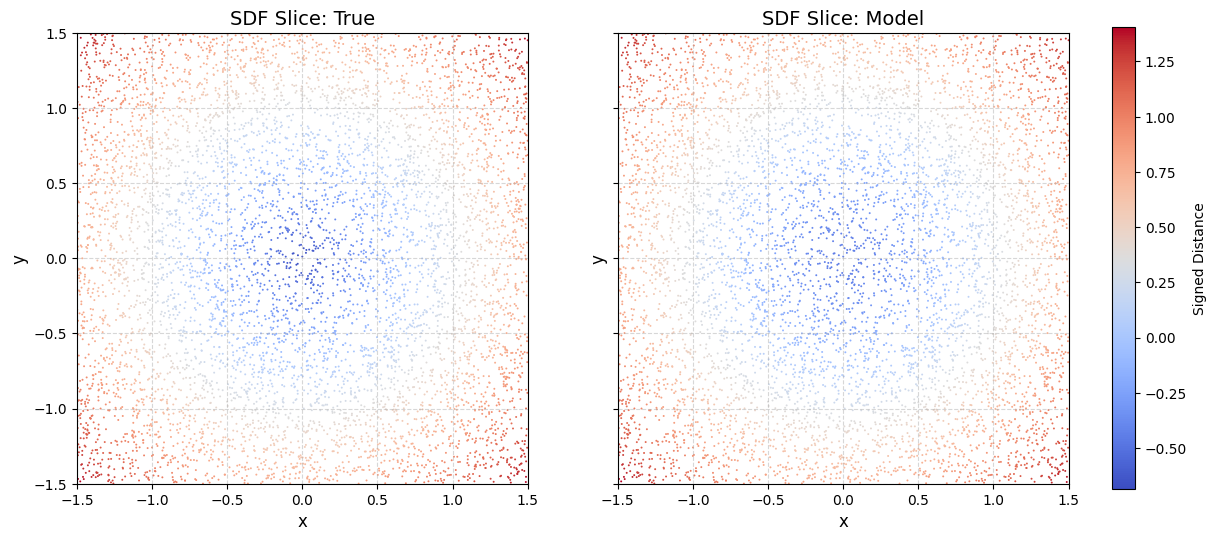

In [132]:
import torch
import matplotlib.pyplot as plt

# --- Generate new Data ---
coords, sdf = generate_sdf_data()

coords_l = LabelTensor(
    coords,
    ["x", "y", "z"]
)
sdf_l = LabelTensor(
    sdf,
    ["sdf"]
)

# --- 2D Slice at z ≈ 0 ---
z_slice_thresh = 0.01  # How close to z=0
mask_2d = (coords_l[:, 2].abs() < z_slice_thresh).reshape(-1)
coords_2d = coords_l[mask_2d]
true_sdf = sdf_l[mask_2d]
model_sdf = solver(coords_l).detach()[mask_2d]

# --- Plot ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Create a common color normalization for both subplots
vmin = min(true_sdf.min(), model_sdf.min())
vmax = max(true_sdf.max(), model_sdf.max())
norm = plt.Normalize(vmin=vmin, vmax=vmax)

# Plot the data on both subplots
for idx, sdf_2d in enumerate([true_sdf, model_sdf]):
    ax = axes[idx]

    # Plot the scatter for the SDF values with shared color normalization
    sc = ax.scatter(
        coords_2d[:, 0],
        coords_2d[:, 1],
        c=sdf_2d.squeeze(),
        cmap="coolwarm",
        s=2,
        edgecolors="none",
        norm=norm,
    )

    ax.set_title(f"SDF Slice: {'True' if idx == 0 else 'Model'}", fontsize=14)
    ax.set_xlabel("x", fontsize=12)
    ax.set_ylabel("y", fontsize=12)
    ax.set_xlim([-1.5, 1.5])  # Set consistent axis limits
    ax.set_ylim([-1.5, 1.5])  # for both plots to have the same scale
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.set_aspect("equal", "box")  # Make sure the plot is square

# Add a colorbar for the entire figure (shared between both plots)
fig.colorbar(sc, ax=axes, label="Signed Distance", fraction=0.046, pad=0.04)

# Title and layout adjustments
plt.show()